# LangGraph 101: Building Multi-Agent Workflows

In this notebook, we're going to walk through setting up a basic  **ReAct Agent** in LangGraph. 

The agent utilizes the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), and is able to handle customer inqueries related to invoice and music. 

![Arch](../images/music_subagent.png) 


For a deeper dive into LangGraph primitives and learning our framework, check out our [LangChain Academy](https://academy.langchain.com/courses/intro-to-langgraph)!


## Pre-work: Setup

#### Loading environment variables

To start, let's load our environment variables from our .env file. Make sure all of the keys necessary in .env.example are included!
We use OpenAI in this example, but feel free to swap ChatOpenAI with other model providers that you prefer. 

In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv(dotenv_path="../.env", override=True)
model = ChatOpenAI(model="o3-mini")

# Note: If you are using another `ChatModel`, you can define it in `models.py` and import it here
# from models import AZURE_OPENAI_GPT_4O
# llm = AZURE_OPENAI_GPT_4O

#### Loading sample customer data

The agent utilizes the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), which contains sample information on customer information, purchase history, and music catalog. 

In [2]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text

    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )

engine = get_engine_for_chinook_db()
db = SQLDatabase(engine)

#### Setting up short-term and long-term memory 

We will also initialize a checkpointer for **short-term memory**, maintaining context within a single thread. 

**Long term memory** lets you store and recall information between conversations. Today, we will utilize our long term memory store to store user preferences for personalization. 



In [3]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

# Initializing long term memory store 
in_memory_store = InMemoryStore()

# Initializing checkpoint for thread-level memory 
checkpointer = MemorySaver()

## Building a ReAct Sub-Agent from Scratch


![react_1](../images/music_subagent.png)

#### State

How does information flow through the steps?  

State is the first LangGraph concept we'll cover. **State can be thought of as the memory of the agent - its a shared data structure that’s passed on between the nodes of your graph**, representing the current snapshot of your application. 

For this our customer support agent our state will track the following elements: 
1. The customer ID
2. Conversation history
3. Memory from long term memory store
4. Remaining steps, which tracks # steps until it hits recursion limit

In [3]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed.is_last_step import RemainingSteps

class State(TypedDict):
    customer_id: str
    messages: Annotated[list[AnyMessage], add_messages]
    loaded_memory: str
    remaining_steps: RemainingSteps 

ModuleNotFoundError: No module named 'langgraph'

#### Tools
Let's define a list of **tools** our agent will have access to. Tools are functionts that can act as extension of the LLM's capabilities. In our case, we will create several tools that interacts with the Chinook database regarding music. 

We can create tools using the @tool decorator to create a tool

In [5]:
from langchain_core.tools import tool
import ast

@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_songs_by_genre(genre: str):
    """
    Fetch songs from the database that match a specific genre.
    
    Args:
        genre (str): The genre of the songs to fetch.
    
    Returns:
        list[dict]: A list of songs that match the specified genre.
    """
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    genre_ids = ast.literal_eval(genre_ids)
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    if not songs:
        return f"No songs found for the genre: {genre}"
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]
llm_with_music_tools = model.bind_tools(music_tools)

#### Nodes

Now that we have a list of tools, we are ready to build nodes that interact with them. 

Nodes are just python (or JS/TS!) functions. Nodes take in your graph's State as input, execute some logic, and return a new State. 

Here, we're just going to set up 2 nodes for our ReAct agent:
1. **music_assistant**: Reasoning node that decides which function to invoke 
2. **music_tools**: Node that contains all the available tools and executes the function

LangGraph has a pre-built ToolNode that we can utilize to create a node for our tools. 

In [6]:
from langgraph.prebuilt import ToolNode
# Node
music_tool_node = ToolNode(music_tools)

In [7]:
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage
from langchain_core.runnables import RunnableConfig

# Music assistant prompt
def generate_music_assistant_prompt(memory: str = "None") -> str:
    return f"""
    You are a member of the assistant team, your role specifically is to focused on helping customers discover and learn about music in our digital catalog. 
    If you are unable to find playlists, songs, or albums associated with an artist, it is okay. 
    Just inform the customer that the catalog does not have any playlists, songs, or albums associated with that artist.
    You also have context on any saved user preferences, helping you to tailor your response. 
    
    CORE RESPONSIBILITIES:
    - Search and provide accurate information about songs, albums, artists, and playlists
    - Offer relevant recommendations based on customer interests
    - Handle music-related queries with attention to detail
    - Help customers discover new music they might enjoy
    - You are routed only when there are questions related to music catalog; ignore other questions. 
    
    SEARCH GUIDELINES:
    1. Always perform thorough searches before concluding something is unavailable
    2. If exact matches aren't found, try:
       - Checking for alternative spellings
       - Looking for similar artist names
       - Searching by partial matches
       - Checking different versions/remixes
    3. When providing song lists:
       - Include the artist name with each song
       - Mention the album when relevant
       - Note if it's part of any playlists
       - Indicate if there are multiple versions
    
    Additional context is provided below: 

    Prior saved user preferences: {memory}
    
    Message history is also attached.  
    """

# Node 
def music_assistant(state: State, config: RunnableConfig): 

    # Fetching long term memory. 
    memory = "None" 
    if "loaded_memory" in state: 
        memory = state["loaded_memory"]

    # Intructions for our agent  
    music_assistant_prompt = generate_music_assistant_prompt(memory)

    # Invoke the model
    response = llm_with_music_tools.invoke([SystemMessage(music_assistant_prompt)] + state["messages"])
    
    # Update the state
    return {"messages": [response]}

#### Edges

Now, we need to define a control flow that connects between our defined nodes, and that's where the concept of edges come in.

**Edges are connections between nodes. They define the flow of the graph.**
* **Normal edges** are deterministic and always go from one node to its defined target
* **Conditional edges** are used to dynamically route between nodes, implemented as functions that return the next node to visit based upon some logic. 

In this case, we want a **conditional edge** from our subagent that determines whether to: 
- Invoke tools, or,
- Route to the end if user query has been finished 

In [8]:
# Conditional edge that determines whether to continue or not
def should_continue(state: State, config: RunnableConfig):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

#### Compile Graph!

Now that we've defined our State and Nodes, let's put it all together and construct our react agent!

USER_AGENT environment variable not set, consider setting it to identify your requests.


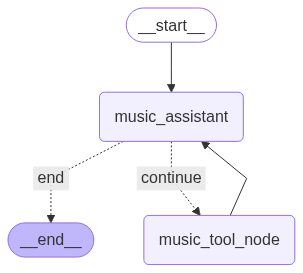

In [9]:
from langgraph.graph import StateGraph, START, END
from utils import show_graph

music_workflow = StateGraph(State)

# Add nodes 
music_workflow.add_node("music_assistant", music_assistant)
music_workflow.add_node("music_tool_node", music_tool_node)


# Add edges 
# First, we define the start node. The query will always route to the subagent node first. 
music_workflow.add_edge(START, "music_assistant")

# We now add a conditional edge
music_workflow.add_conditional_edges(
    "music_assistant",
    # Function representing our conditional edge
    should_continue,
    {
        # If `tools`, then we call the tool node.
        "continue": "music_tool_node",
        # Otherwise we finish.
        "end": END,
    },
)

music_workflow.add_edge("music_tool_node", "music_assistant")

music_catalog_subagent = music_workflow.compile(name="music_catalog_subagent", checkpointer=checkpointer, store = in_memory_store)
show_graph(music_catalog_subagent)

#### Testing

Let's see how it works!

In [10]:
import uuid
thread_id = uuid.uuid4()

question = "I like the Rolling Stones. What songs do you recommend by them or by other artists that I might like?"
config = {"configurable": {"thread_id": thread_id}}

result = music_catalog_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)

for message in result["messages"]:
   message.pretty_print()

================================ Human Message =================================

I like the Rolling Stones. What songs do you recommend by them or by other artists that I might like?
================================== Ai Message ==================================
Tool Calls:
  get_tracks_by_artist (call_2gkEtzvPAR1dwRHoFKxsxrpp)
 Call ID: call_2gkEtzvPAR1dwRHoFKxsxrpp
  Args:
    artist: Rolling Stones
================================= Tool Message =================================
Name: get_tracks_by_artist

[{'SongName': 'Time Is On My Side', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Heart Of Stone', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Play With Fire', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Satisfaction', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'As Tears Go By', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Get Off Of My Cloud', 'ArtistName': 'The Rolling Stones'}, {'SongName': "Mother's Little Helper", 'ArtistName': 'The Rolling St